# Blood Bladder project pseudotime analysis on shared TCR clusters

This ipython notebook is originally part of the Molecular Systems Biology submission 'Best practices in single-cell RNA-seq analysis: a tutorial'. 

Here, modified version on Apexigen project for fong lab. This notebook is intended to illustrate a typical single-cell RNA-seq analysis pipeline using current best practices and common tools. 

If the relevant libraries and modules have been installed on the system, they must be loaded. The scanpy api gives access to all tools availalbe via the scanpy platform. Numpy and scipy are useful scientific computing libraries that are used by scanpy, and pandas is used to load in the data. Pandas is also the basis of the data structures used in scanpy (the Anndata module). Matplotlib and seaborn are used for plotting.

R libraries that are used in this tutorial include:
- scran for preprocessing
- MAST for differential expression analysis
- RColorBrewer and clusterExperiment for visualization in R
- ComplexHeatmap for heatmap plotting


## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#Subclustering>3.3 Subclustering</a>
    * <a href=#Compositions>3.4 Compositional analysis</a>
    * <a href=#Gene-level>3.5 Gene-level analysis</a>
      * <a href=#Diff_expr>3.5.1 Differential expression</a>
      * <a href=#Gene_set>3.5.2 Gene set analysis</a>
    * <a href=#Write>3.6 Writing to file</a>


# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
OpenSSL             19.1.0
PIL                 7.0.0
PyObjCTools         NA
anndata2ri          1.0.2
appnope             0.1.0
backcall            0.1.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
cairo               1.21.0
certifi             2019.11.28
cffi                1.14.0
chardet             3.0.4
cloudpickle         1.3.0
colorama            0.4.3
cryptography        2.8
cycler              0.10.0
cython_ru

In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)

library(ggplot2)
library(plyr)
library(MAST)

In [4]:
# library(clusterExperiment) 
# There is some issue to install this R package in wynton. 

<a id="Reading"></a>

# 1. Reading in the data

Note that single cell data exists in many formats and loading data may therefore require preprocessing. Packages like Scanpy and Seurat facilitate the data loading process by supporting several sparse and dense data formats in their read functions. When adapting the tutorial code to your own dataset, you will likely have to make changes to this section to match to the format of your data.

Here, we are reading in sparse count matrices, but are immediately converting these to dense representation with the .toarray() function. We create dense matrices as our batch correction method outputs a dense expression matrix, and the data transfer between R and python is currently limited to dense matrices. When sparse batch correction methods are available, and rpy2 is extended to sparse matrices, it is more memory-efficient to keep the data in a sparse format.

It should also be noted that the conventions for storing single cell data differ between R (Seurat, or Scater) and python platforms (Scanpy). Scanpy expects the data to be stored in the format cells x genes, while R platforms expect the transpose. As data is typically stored in the format genes x cells in the GEO, we must transpose the data before using it.

Finally, the `regev_lab_cell_cycle_genes.txt` contains a list of marker genes for different cell cycle phases. It can be ignored for now. We come back to this file in the <a href=#CC>Cell cycle scoring</a> section.



Once the data is read in and annotated, we test whether we have the expected number of cells for each comp, patient, sample and treatment.

In [4]:
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly.h5ad"
adata = sc.read(adata_file)
adata
# only 2028 genes means there is only highly_variable in the data, need to get the raw data.

AnnData object with n_obs × n_vars = 157054 × 2028 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [5]:
# read adata raw
# path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
# adata_file = path + "bladder_total_adata_multiplex_preprocess_9.15.h5ad"
# adata_raw = sc.read(adata_file)
# adata_raw

In [6]:
#subset adata_raw to cells in adata_mono
# adata_raw = adata_raw[adata.obs.index]
# adata_raw

In [7]:
# Checking the total size of the data set
# adata_raw.shape

In [8]:
# Checking the total size of the data set
adata.shape

(157054, 2028)

In [9]:
# merege TCR data

In [10]:
adata.obs["cell.barcode"] = adata.obs.index.map(lambda x: x[0:14])
adata.obs["cell.barcode"].head()

index
AAACATTGCTTGGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACATTGCTTGGA
AAACCGTGCACCAA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACCGTGCACCAA
AAACCGTGTGCCCT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACCGTGTGCCCT
AAACGGCTCCTTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACGGCTCCTTGC
AAACGGCTGTCTAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0    AAACGGCTGTCTAG
Name: cell.barcode, dtype: object

In [11]:
# merge cell metadata with TCR info from csv

In [12]:
# cell_info_TCR = pd.read_csv("/wynton/group/fong/hyang7/bladder_blood_analysis/metadata/Bladder_TCR_match_paper_cell_level_w_all_cluster_stats_subset_data_merged_w_soc_10.26.csv", header=0)
cell_info_TCR = pd.read_csv("/wynton/group/fong/hyang7/bladder_blood_analysis/metadata/Bladder_TCR_match_paper_cell_level_w_all_cluster_stats_subset_data_merged_w_soc_expansion1.csv", header=0)

In [13]:
cell_info_TCR['degree'] = cell_info_TCR['deg']

In [14]:
cell_info_TCR.columns

Index(['Unnamed: 0', 'Sample_ID', 'cell.barcode', 'alphaClonalSeq',
       'alphaCDR3', 'alphaVGene', 'alphaJGene', 'alphaDGene', 'betaClonalSeq',
       'betaCDR3', 'betaVGene', 'betaJGene', 'betaDGene', 'cloneCount',
       'Pop..ID', 'patient', 'comp', 'tissue', 'treatment', 'MAIT', 'iNKT',
       'ab', 'count', 'expand', 'louvain', 'leiden', 'cell_type',
       'alphacloneCount', 'betacloneCount', 'cluster_id', 'blood_tumor',
       'expansion', 'GZMB', 'GZMK', 'GZM', 'Tregs_index', 'betaCDR3_length',
       'alphaCDR3_length', 'deg', 'transitivity', 'closeness', 'centr_clo_res',
       'eigen_centrality', 'centr_eigen', 'betweenness', 'centr_betw',
       'authority_score', 'coreness', 'page_rank', 'membership_stat',
       'TCR_cluster_id', 'TCR_size_gt1', 'degree'],
      dtype='object')

In [15]:
cell_info_TCR['treatment'].value_counts()

atezo    24171
soc      20040
pre      12073
Name: treatment, dtype: int64

In [16]:
cell_info_TCR.shape

(56284, 53)

In [17]:
cell_info_TCR["cell.barcode"].head()

0    CACTCTCTCCTCGT
1    TAACAATGATAAGG
2    CATAAATGACGGAG
3    GCACACCTGAACCT
4    TAGAGCACTTCCCG
Name: cell.barcode, dtype: object

In [18]:
adata.obs['index_col'] = adata.obs.index

In [19]:
merge_obs = pd.merge(adata.obs, cell_info_TCR, left_on='cell.barcode', right_on='cell.barcode', how= "left")

In [20]:
merge_obs = merge_obs.set_index('index_col')

In [21]:
merge_obs.shape

(157054, 73)

In [22]:
# only work if the index are same
adata.obs['degree'] = merge_obs['degree']
adata.obs['tcr_cluster_id'] = merge_obs['TCR_cluster_id']
adata.obs['expansion'] = merge_obs['expansion']
adata.obs['blood_tumor'] = merge_obs['blood_tumor']
adata.obs['expand'] = merge_obs['expand']
adata.obs['tcr_alpha_beta'] = merge_obs['ab']

In [23]:
adata.obs["expansion"].isnull().value_counts()

True     100769
False     56285
Name: expansion, dtype: int64

In [24]:
adata.obs["expansion"].value_counts()

non-expanded    39325
expanded        16960
Name: expansion, dtype: int64

In [25]:
adata

AnnData object with n_obs × n_vars = 157054 × 2028 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [26]:
adata[(adata.obs['patient'] == "a5") & (adata.obs['comp'] == "CD4") & (adata.obs['tissue'] == "blood") & (adata.obs['treatment'] == "atezo"),:].obs['cell_calls'].value_counts()

Naive           1582
Mito            1142
GZMB+            614
CXCL13+          600
CM               398
Tregs            143
Prolif GZMK+      52
GZMK+             48
MAIT               3
IFN+               2
Name: cell_calls, dtype: int64

In [35]:
path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update.h5ad"
adata.write(adata_file)
adata

... storing 'tcr_cluster_id' as categorical
... storing 'expansion' as categorical
... storing 'blood_tumor' as categorical
... storing 'expand' as categorical
... storing 'tcr_alpha_beta' as categorical


AnnData object with n_obs × n_vars = 157054 × 2028 
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [36]:
file_path = "/wynton/group/fong/hyang7/bladder_blood_analysis/metadata/"
adata.obs.to_csv(file_path + "bladder_total_adata_multiplex_Tcellonly_obs_data_w_TCR_info_update.csv")

<a id="Preprocessing"></a>

<a id="CC"></a>

<a id="Compositions"></a>

## 3.5 Trajectory inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

Based on a recent comparison of pseudotime methods [Saelens et al., 2018], we have selected the top performing 'Slingshot', 'Monocle2', and 'Diffusion Pseudotime (DPT)'. Three methods were chosen as trajectory inference is a complex problem which is not yet solved. Different methods perform well on different types of trajectories. For example, 'Slingshot' was the top performer for simple bifurcating and multifurcating trajectories; 'Monocle2' performed best for complex tree structures, and 'DPT' performed well in bifurcating trajectories and was used in the Haber et al paper from which we took this dataset. As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.

In [4]:
# path = "/wynton/group/fong/hyang7/bladder_blood_analysis/obj/"
path = "/Users/hai/Documents/workstation/bladder_blood_analysis/metadata/"
adata_file = path + "bladder_total_adata_multiplex_Tcellonly_w_TCR_info_update.h5ad"
adata = sc.read(adata_file)
adata

/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 157054 × 2028
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [5]:
adata.obs['blood_tumor'].value_counts()

nan           100769
non-shared     49790
shared          6495
Name: blood_tumor, dtype: int64

In [6]:
adata.obs['cell_calls'].value_counts()

Naive           34759
GZMB+           27399
Mito            23597
CM              21247
GZMK+           19371
CXCL13+         17210
Tregs            8777
Prolif GZMK+     2408
MAIT             1680
Activated         518
IFN+               88
Name: cell_calls, dtype: int64

In [7]:
adata.obs['patient'].value_counts()

a4    29980
a5    21505
a2    21045
a3    18203
s3    16643
s2    15048
s1    14069
h2     7324
h1     6857
h3     6380
Name: patient, dtype: int64

In [8]:
# create a column based on patient, replace value based on the following rule

# "a2"  <- "Anti-PD-L1 A" 
# "a3"  <- "Anti-PD-L1 B" 
# "a4"  <- "Anti-PD-L1 C" 
# "a5"  <- "Anti-PD-L1 D" 
# "a6"  <- "Anti-PD-L1 E" 
# "s1"  <- "Chemo" 
# "s2"  <- "Untreated A" 
# "s3"  <- "Untreated B" 
adata.obs['Patient_ID'] = adata.obs['patient']
adata.obs['patient'].replace({"a2": "Anti-PD-L1 A", "a3": "Anti-PD-L1 B", "a4": "Anti-PD-L1 C", "a5": "Anti-PD-L1 D", "a6": "Anti-PD-L1 E", "s1": "Chemo", "s2": "Untreated A", "s3": "Untreated B"}, inplace=True)
adata.obs['patient'].value_counts()

Anti-PD-L1 C    29980
Anti-PD-L1 D    21505
Anti-PD-L1 A    21045
Anti-PD-L1 B    18203
Untreated B     16643
Untreated A     15048
Chemo           14069
h2               7324
h1               6857
h3               6380
Name: patient, dtype: int64

In [9]:
adata.obs['treatment'].value_counts()

atezo      59880
soc        45760
pre        30853
healthy    20561
Name: treatment, dtype: int64

In [10]:
# data on shared 

In [11]:
adata_shared = adata[adata.obs['blood_tumor'] == "shared",:]
adata_shared.shape

(6495, 2028)

In [12]:
# subset data on soc only, which is only include Untreated B and Untreated A
adata_shared_soc = adata_shared[adata_shared.obs['patient'].isin(["Untreated A", "Untreated B", "Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D"]),:]
adata_shared_soc.shape

(5345, 2028)

In [13]:
adata = adata_shared_soc
adata

View of AnnData object with n_obs × n_vars = 5345 × 2028
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta', 'Patient_ID'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [14]:
adata.obs['patient'].value_counts()

Anti-PD-L1 D    1445
Untreated B     1273
Untreated A      926
Anti-PD-L1 C     854
Anti-PD-L1 B     847
Name: patient, dtype: int64

### 3.5.3 Monocle2

The monocle toolbox is one of the most popular trajectory inference toolboxes in the field. It has been shown to perform particularly well on complex trajectories. Although we only have a simple bi- or multifurcating trajectory here we use Monocle2 to confirm the obtained trajectory.

Monocle2 is not as much a standalone trajectory inference method, than a trajectory inference toolbox. This toolbox includes preprocessing steps and a dimensionality reduction function. It is designed in such a way that integrating preprocessed data into the data structure is non-trivial. This is likely by intent to not interfere with the optimized pipeline. Thus, we use Monocle2 on our data set from the raw data. Our cluster labels are later overlayed onto the Monocle2 output to compare the trajectory with expectations.

Implementation note:

this section closely follows the monocle 2 tutorial

In [15]:
adata.obs['cell_calls'].value_counts()

GZMB+           2971
GZMK+           1437
Prolif GZMK+     260
Mito             221
Naive            120
CM               118
CXCL13+          113
Tregs             75
MAIT              22
Activated          6
IFN+               2
Name: cell_calls, dtype: int64

In [16]:
adata.obs['expansion'].value_counts()

expanded    5345
Name: expansion, dtype: int64

In [17]:
adata.obs['treatment'].value_counts()

soc      2199
atezo    1634
pre      1512
Name: treatment, dtype: int64

In [18]:
adata.obs['tissue'].value_counts()

blood    4689
tumor     656
Name: tissue, dtype: int64

In [19]:
# create column: pre-blood and post-blood and atezo-tumor

In [20]:
adata.obs['tissue_time'] = ''
adata.obs.loc[(adata.obs['tissue'] == "blood") & (adata.obs['treatment'].isin(["pre"])) ,'tissue_time'] = 'pre-blood'
adata.obs.loc[(adata.obs['tissue'] == "blood") & (adata.obs['treatment'].isin(["atezo"])) ,'tissue_time'] = 'post-blood'
adata.obs.loc[(adata.obs['tissue'] == "tumor") & (adata.obs['treatment'].isin(["atezo"])) ,'tissue_time'] = 'atezo-tumor'

Trying to set attribute `.obs` of view, copying.


In [21]:
adata.obs['tissue_time'].value_counts()

               2199
pre-blood      1512
post-blood     1315
atezo-tumor     319
Name: tissue_time, dtype: int64

In [22]:
pd.crosstab(adata.obs['tissue'],adata.obs['treatment'])


treatment,atezo,pre,soc
tissue,,,
blood,1315,1512,1862
tumor,319,0,337


# Data on shared and CD8; 

# Data on shared and CD8; subset exclude health, (get soc back in data)

In [100]:
adata_expanded_cd8_sub = adata[(adata.obs['comp'] == "CD8") & (adata.obs['cell_calls'].isin(["GZMB+","GZMK+","Prolif GZMK+","CXCL13+",'Tregs','MAIT'])),:]
adata_expanded_cd8_sub.shape
adata_test = adata_expanded_cd8_sub
adata_test

View of AnnData object with n_obs × n_vars = 3873 × 2028
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta', 'Patient_ID', 'tissue_time'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [101]:
adata_expanded_cd8_sub.obs['cell_calls'].value_counts()

GZMB+           2323
GZMK+           1257
Prolif GZMK+     230
CXCL13+           37
MAIT              21
Tregs              5
Name: cell_calls, dtype: int64

In [102]:
adata_expanded_cd8_sub.obs['tissue_time'].value_counts()

               1831
post-blood     1076
pre-blood       777
atezo-tumor     189
Name: tissue_time, dtype: int64

In [103]:
#Preprocessing for monocle
data_mat_mon = adata_test.layers['counts'].T
var_mon=adata_test.var.copy()
obs_mon=adata_test.obs.copy()

In [104]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$cell_calls)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("GZMB+","GZMK+","CXCL13+","Tregs","Mito","Naive","Prolif GZMK+","CM","MAIT","Activated","IFN+")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

# #Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$cell_calls)
id = which(colnames(tab1) == 'GZMB+')
root_name = names(which.max(tab1[,id]))

# #Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 3873
[1] ""


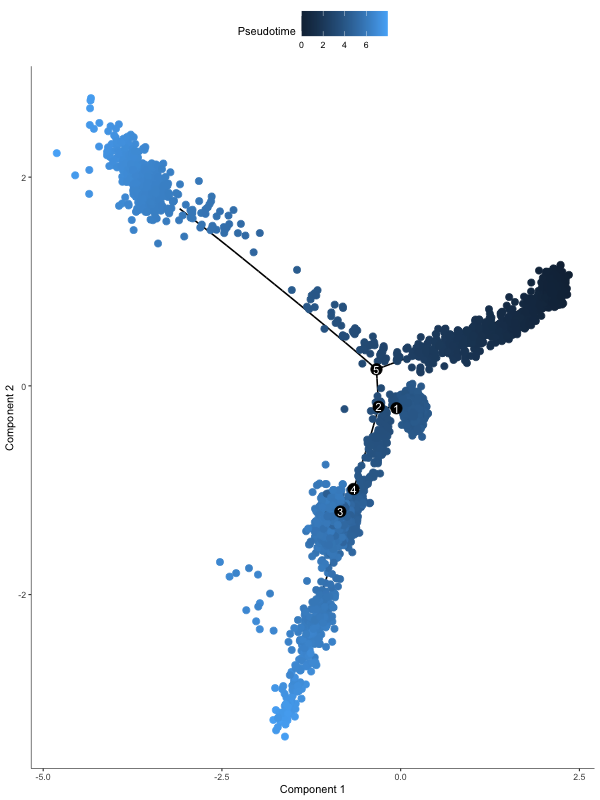

In [28]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")

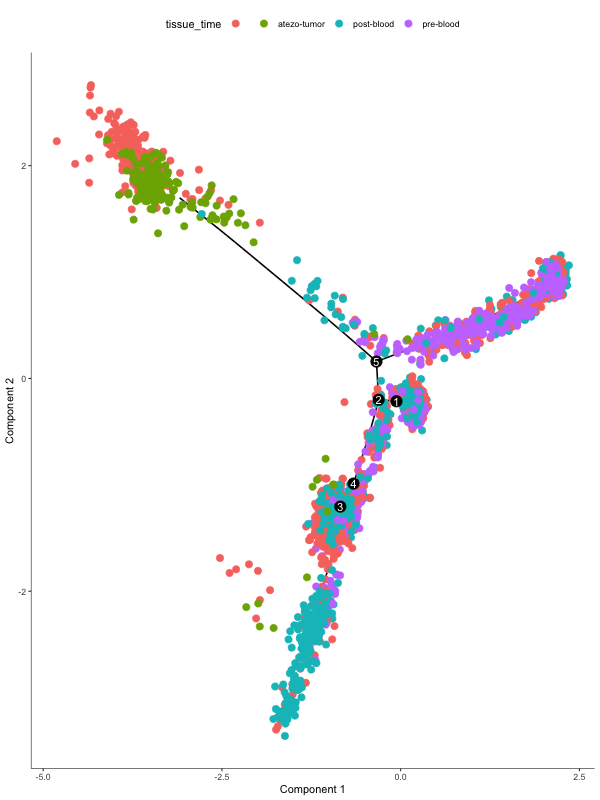

In [29]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue_time")

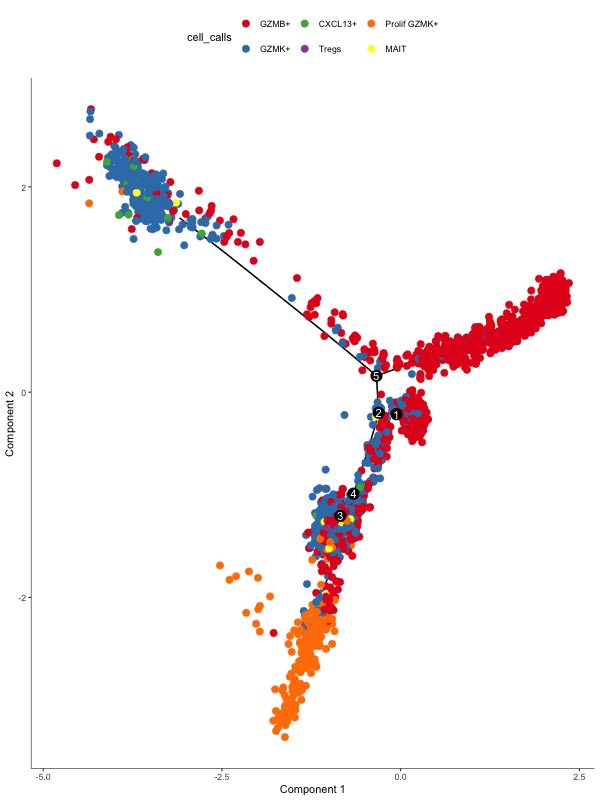

In [30]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="cell_calls") + scale_color_brewer(palette = "Set1")

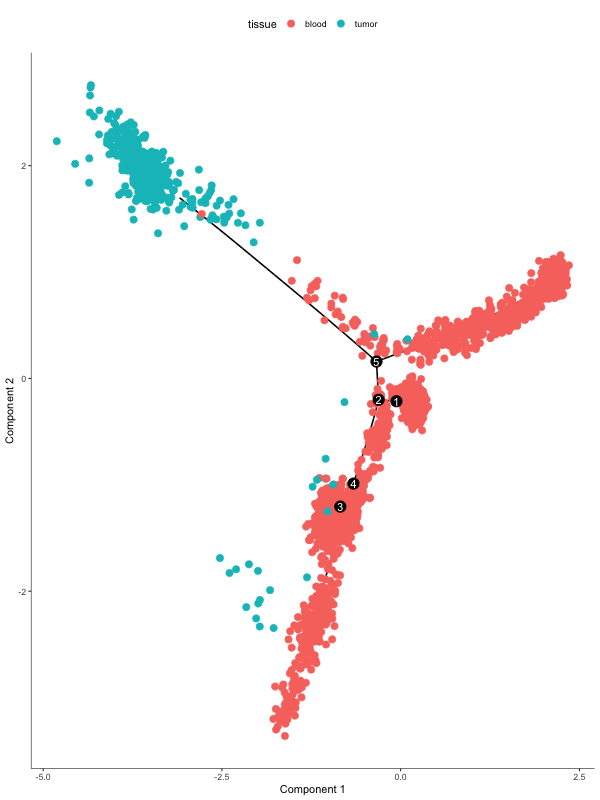

In [31]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue")

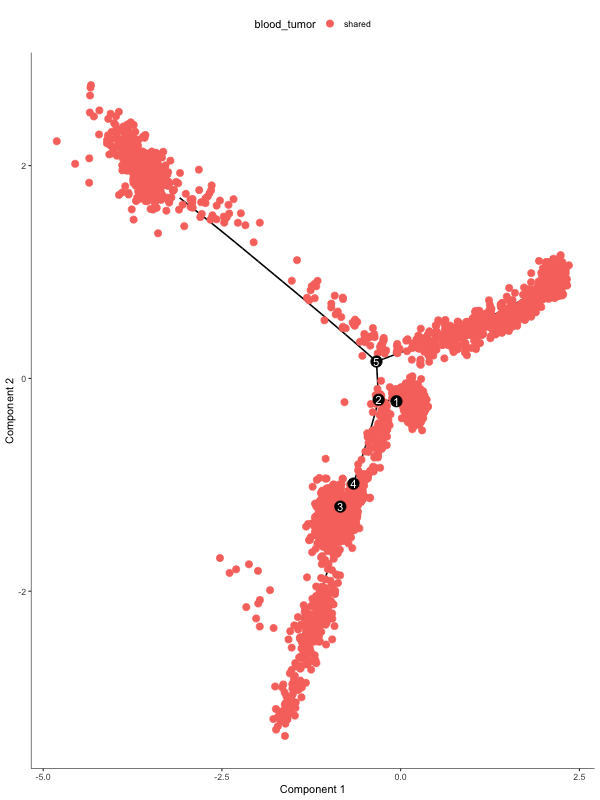

In [32]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="blood_tumor")

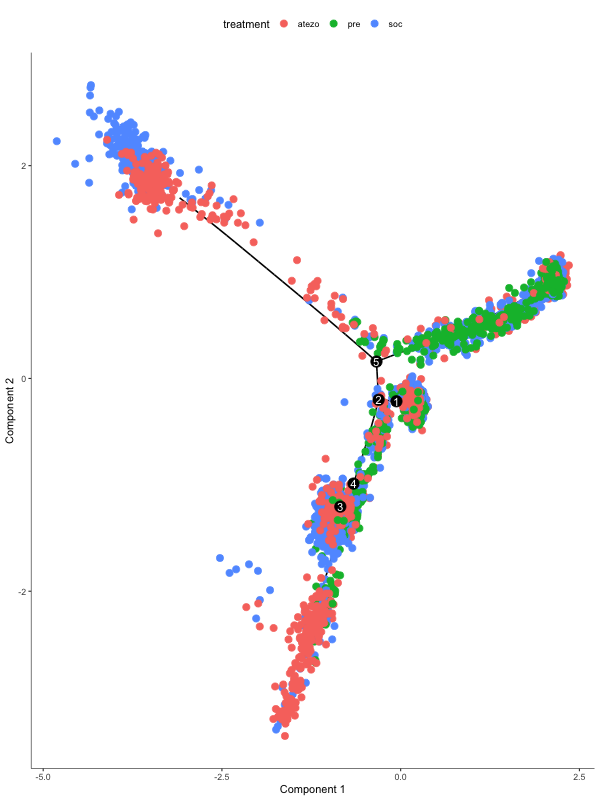

In [33]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="treatment")

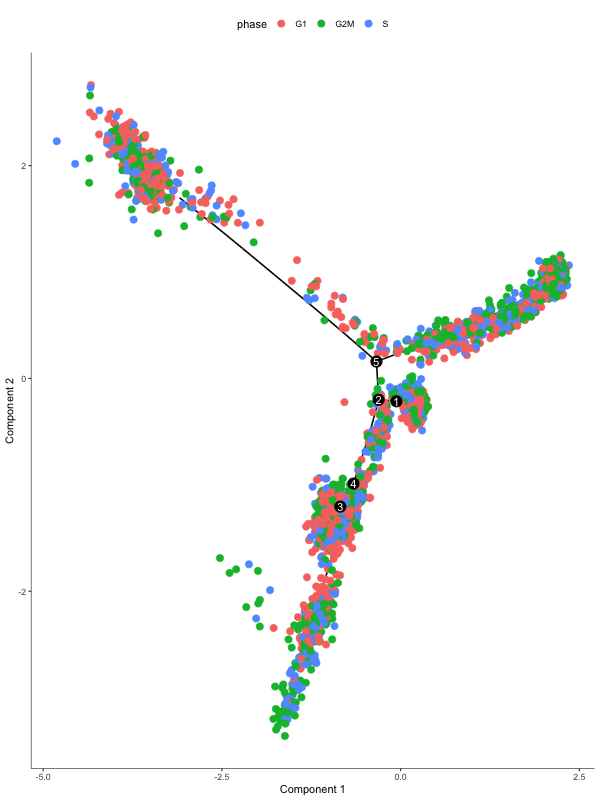

In [34]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="phase")

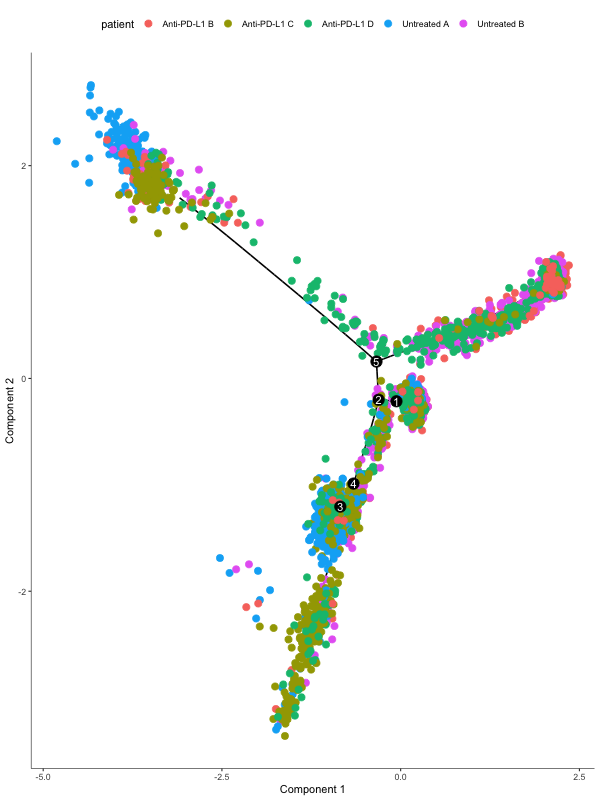

In [35]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="patient")

In [36]:
%%R -w 600 -h 800
pdf("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/save_pseudotime_plot_CD8_shared_SOC_and_atezo.pdf")
#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue_time")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="cell_calls")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="blood_tumor")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="treatment")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="phase")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="patient")
print(p)
dev.off()

[1] 2


In [105]:
%%R
# Subset the data atezo
# Anti-PD-L1 D    592
# Anti-PD-L1 C    211
# Untreated B     134
# Untreated A      51
# Anti-PD-L1 B     17
subset_data <- ie_regions_cds[,ie_regions_cds$patient %in% c("Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D", "Untreated A", "Untreated B") ]
subset_data
print(table(pData(subset_data)$patient))


Anti-PD-L1 B Anti-PD-L1 C Anti-PD-L1 D  Untreated A  Untreated B 
         784          560          698          824         1007 


In [106]:
%%R

#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(subset_data)$cell_calls)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("GZMB+","GZMK+","CXCL13+","Tregs","Mito","Naive","Prolif GZMK+","CM","MAIT","Activated","IFN+")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")


#Filter highly variable genes from our analysis
hvg_mask = fData(subset_data)$highly_variable
subset_data <- subset_data[hvg_mask, cell_mask]

#Do dimensionality reduction
subset_data <- reduceDimension(subset_data, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
subset_data <- orderCells(subset_data)

# #Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(subset_data)$State, pData(subset_data)$cell_calls)
id = which(colnames(tab1) == 'GZMB+')
root_name = names(which.max(tab1[,id]))

# #Run a second time to get the correct root state that overlaps with Stem cells
subset_data <- orderCells(subset_data, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 3873
[1] ""


In [107]:
%%R
print(dim(subset_data))
cds <- subset_data
x = 1
 y = 2
  color_by = "State"
   show_tree = TRUE 
    show_backbone = TRUE
     backbone_color = "black"
      markers = NULL
    use_color_gradient = FALSE
     markers_linear = FALSE
      show_cell_names = FALSE 
    show_state_number = FALSE
     cell_size = 1.5
      cell_link_size = 0.75 
    cell_name_size = 2
     state_number_size = 2.9
      show_branch_points = TRUE 
    theta = 0

Features  Samples 
    2028     3873 


In [108]:
%%R
library(magrittr)
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)

library(ggplot2)
library(plyr)
library(MAST)
library(dplyr)
library(tibble)

# Load required namespace
    requireNamespace("igraph")

    # Initial variable declarations
    gene_short_name <- NA
    sample_name <- NA
    sample_state <- pData(cds)$State
    data_dim_1 <- NA
    data_dim_2 <- NA
    lib_info_with_pseudo <- pData(cds)

    # Check for dimension reduction
    if (is.null(cds@dim_reduce_type)) {
        stop("Error: dimensionality not yet reduced. Please call reduceDimension() before calling this function.")
    }

    # Fetch reduced dimensional coordinates based on dimension reduction type
    if (cds@dim_reduce_type == "ICA") {
        reduced_dim_coords <- reducedDimS(cds)
    } else if (cds@dim_reduce_type %in% c("simplePPT", "DDRTree")) {
        reduced_dim_coords <- reducedDimK(cds)
    } else {
        stop("Error: unrecognized dimensionality reduction method.")
    }
    # Transform reduced dimension data to dataframe
    ica_space_df <- Matrix::t(reduced_dim_coords) %>% as.data.frame() %>% 
        select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>% 
        mutate(sample_name = rownames(.), sample_state = rownames(.))


    # Minimum spanning tree
    dp_mst <- minSpanningTree(cds)
    if (is.null(dp_mst)) {
        stop("You must first call orderCells() before using this function")
    }

    # Edge data frame preparation
    edge_df <- dp_mst %>% igraph::as_data_frame() %>% select_(source = "from", 
        target = "to") %>% left_join(ica_space_df %>% select_(source = "sample_name", 
        source_prin_graph_dim_1 = "prin_graph_dim_1", source_prin_graph_dim_2 = "prin_graph_dim_2"), 
        by = "source") %>% left_join(ica_space_df %>% select_(target = "sample_name", 
        target_prin_graph_dim_1 = "prin_graph_dim_1", target_prin_graph_dim_2 = "prin_graph_dim_2"), 
        by = "target")
    # Data frame preparation
    data_df <- t(monocle::reducedDimS(cds)) %>% as.data.frame() %>% 
        select_(data_dim_1 = x, data_dim_2 = y) %>% rownames_to_column("sample_name") %>% 
        mutate(sample_state) %>% left_join(lib_info_with_pseudo %>% 
        rownames_to_column("sample_name"), by = "sample_name")

    # Function to get rotation matrix
    return_rotation_mat <- function(theta) {
        theta <- theta/180 * pi
        matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2)
    }

In [109]:
%%R
# Rotate data
    rot_mat <- return_rotation_mat(theta)
    cn1 <- c("data_dim_1", "data_dim_2")
    cn2 <- c("source_prin_graph_dim_1", "source_prin_graph_dim_2")
    cn3 <- c("target_prin_graph_dim_1", "target_prin_graph_dim_2")
    data_df[, cn1] <- as.matrix(data_df[, cn1]) %*% t(rot_mat)
    edge_df[, cn2] <- as.matrix(edge_df[, cn2]) %*% t(rot_mat)
    edge_df[, cn3] <- as.matrix(edge_df[, cn3]) %*% t(rot_mat)

    # Marker expressions processing
    markers_exprs <- NULL
    if (is.null(markers) == FALSE) {
        markers_fData <- subset(fData(cds), gene_short_name %in% 
            markers)
        if (nrow(markers_fData) >= 1) {
            markers_exprs <- reshape2::melt(as.matrix(exprs(cds[row.names(markers_fData), 
                ])))
            colnames(markers_exprs)[1:2] <- c("feature_id", "cell_id")
            markers_exprs <- merge(markers_exprs, markers_fData, 
                by.x = "feature_id", by.y = "row.names")
            markers_exprs$feature_label <- as.character(markers_exprs$gene_short_name)
            markers_exprs$feature_label[is.na(markers_exprs$feature_label)] <- markers_exprs$Var1
        }
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        data_df <- merge(data_df, markers_exprs, by.x = "sample_name", 
            by.y = "cell_id")
        if (use_color_gradient) {
            if (markers_linear) {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2)) + geom_point(aes(color = value), 
                  size = I(cell_size), na.rm = TRUE) + scale_color_viridis(name = paste0("value"), 
                  ...) + facet_wrap(~feature_label)
            }
            else {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2)) + geom_point(aes(color = log10(value + 
                  0.1)), size = I(cell_size), na.rm = TRUE) + 
                  scale_color_viridis(name = paste0("log10(value + 0.1)"), 
                    ...) + facet_wrap(~feature_label)
            }
        }
        else {
            if (markers_linear) {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2, size = (value * 0.1))) + facet_wrap(~feature_label)
            }
            else {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2, size = log10(value + 0.1))) + 
                  facet_wrap(~feature_label)
            }
        }
    }
    else {
        g <- ggplot(data = data_df, aes(x = data_dim_1, y = data_dim_2))
    }

### All CD8 as input

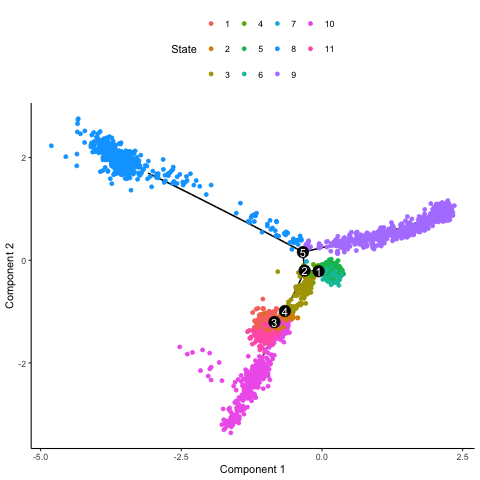

In [110]:
%%R
g <- ggplot(data = data_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

### atezo CD8 as input

In [111]:
%%R
# for loop on color codes
atezoCD8_df <- data_df[data_df$patient %in% c("Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D"),]
cell_size = 3

for(color_by in c("patient", "tissue_time", "cell_calls", "tissue", "blood_tumor", "treatment", "phase", "patient")){

# color_by = "patient"


g <- ggplot(data = atezoCD8_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

    pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD8_atezo_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    dev.off()
}

### Untreated  A B CD8 as input

In [112]:
%%R
# for loop on color codes
Untreated_df <- data_df[data_df$patient %in% c("Untreated A", "Untreated B"),]
cell_size = 3

for(color_by in c("patient", "tissue_time", "cell_calls", "tissue", "blood_tumor", "treatment", "phase", "patient")){

# color_by = "patient"


g <- ggplot(data = Untreated_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

    pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD8_Untreated_SOC_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    dev.off()
}

# Data on shared and CD4; subset exclude health, (get soc back in data)

In [23]:
adata_expanded_cd4_sub = adata[(adata.obs['comp'] == "CD4") & (adata.obs['cell_calls'].isin(["GZMB+","GZMK+","Prolif GZMK+","CXCL13+",'Tregs','MAIT'])),:]
adata_expanded_cd4_sub.shape
adata_test = adata_expanded_cd4_sub
adata_test

View of AnnData object with n_obs × n_vars = 1005 × 2028
    obs: 'RBC', 'batch', 'comp', 'n_counts', 'n_genes', 'patient', 'percent_mito', 'platelet', 'sample', 'tissue', 'treatment', 'louvain', 'leiden', 'umap_density_comp', 'umap_density_treatment', 'umap_density_tissue', 'cell_calls', 'S_score', 'G2M_score', 'phase', 'cell.barcode', 'index_col', 'degree', 'tcr_cluster_id', 'expansion', 'blood_tumor', 'expand', 'tcr_alpha_beta', 'Patient_ID', 'tissue_time'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_calls_colors', 'comp_colors', 'dendrogram_cell_calls', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'tissue_colors', 'treatment_colors', 'umap_density_comp_params', 'umap_density_tissue_params', 'umap_density_treatment_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [24]:
adata_test.obs['cell_calls'].value_counts()

GZMB+           648
GZMK+           180
CXCL13+          76
Tregs            70
Prolif GZMK+     30
MAIT              1
Name: cell_calls, dtype: int64

In [25]:
adata_test.obs['patient'].value_counts()

Anti-PD-L1 D    592
Anti-PD-L1 C    211
Untreated B     134
Untreated A      51
Anti-PD-L1 B     17
Name: patient, dtype: int64

In [26]:
adata_test.obs['tissue_time'].value_counts()

pre-blood      555
               185
post-blood     154
atezo-tumor    111
Name: tissue_time, dtype: int64

In [27]:
#Preprocessing for monocle
data_mat_mon = adata_test.layers['counts'].T
var_mon=adata_test.var.copy()
obs_mon=adata_test.obs.copy()

In [28]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$cell_calls)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("GZMB+","GZMK+","CXCL13+","Tregs","Mito","Naive","Prolif GZMK+","CM","MAIT","Activated","IFN+")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]

#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)

# #Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$cell_calls)
id = which(colnames(tab1) == 'GZMB+')
root_name = names(which.max(tab1[,id]))

# #Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 1005
[1] ""


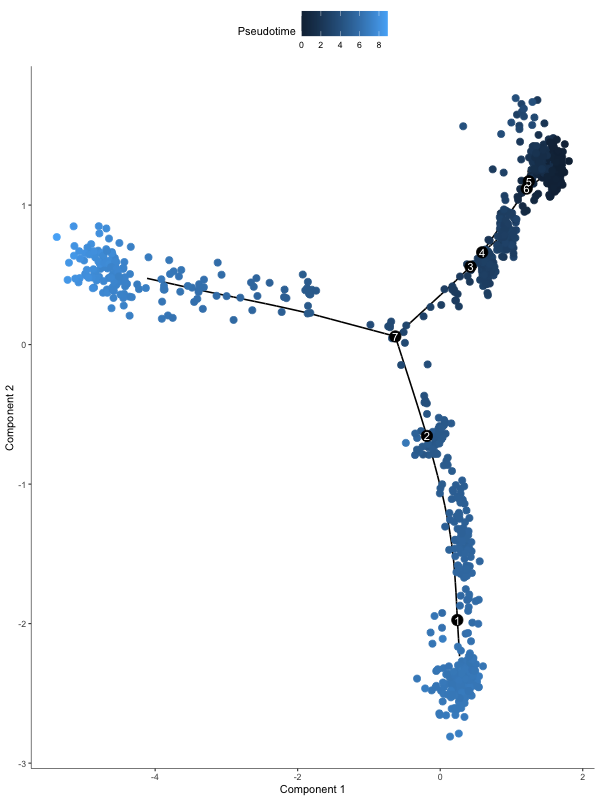

In [29]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")

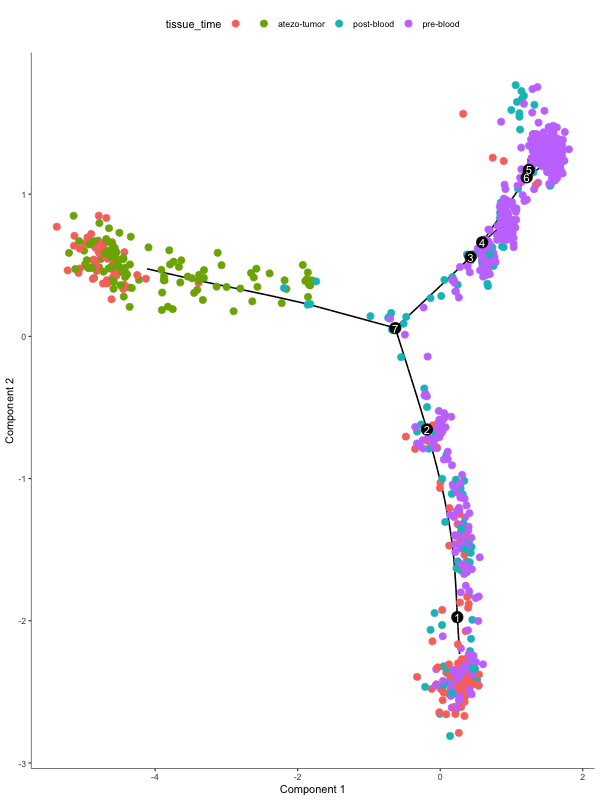

In [30]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue_time")

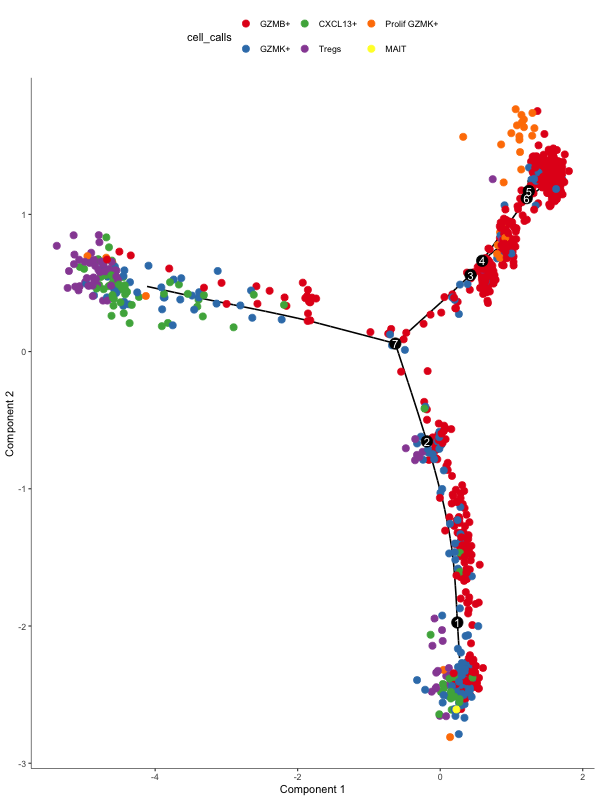

In [31]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="cell_calls") + scale_color_brewer(palette = "Set1")

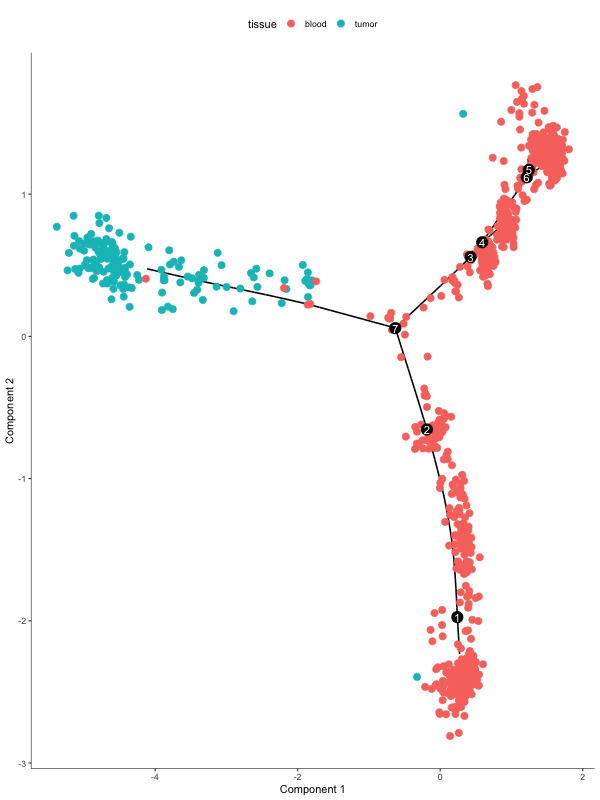

In [32]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue")

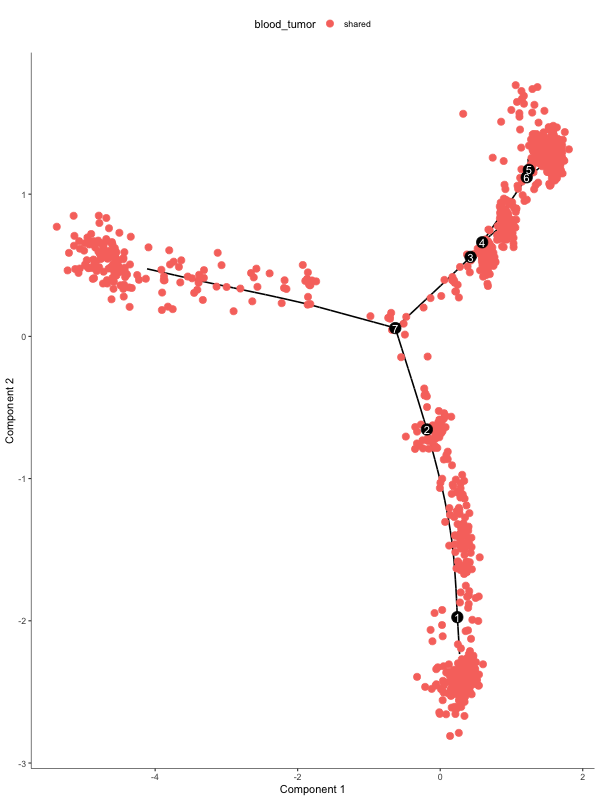

In [33]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="blood_tumor")

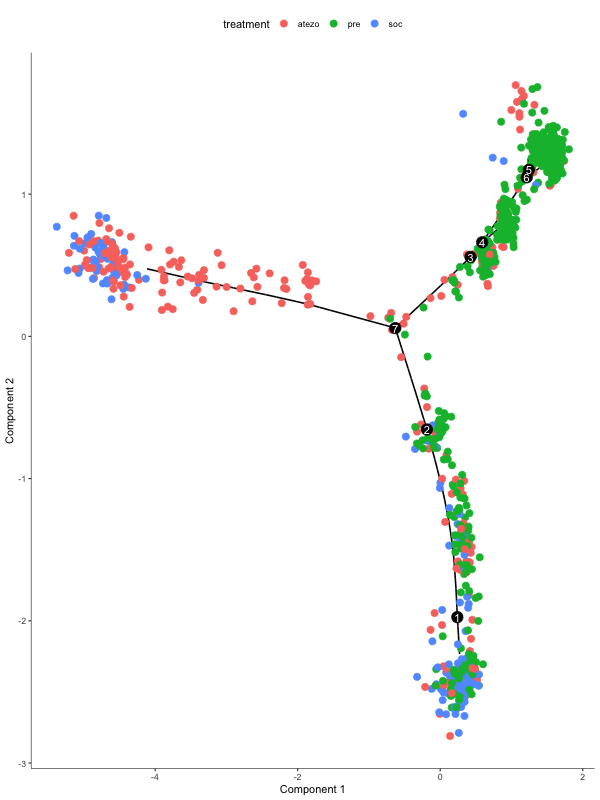

In [34]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="treatment")

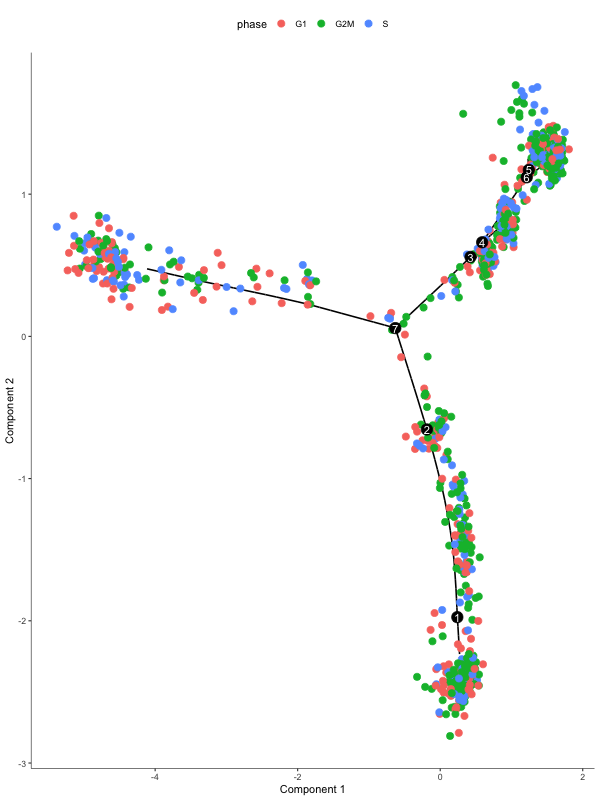

In [35]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="phase")

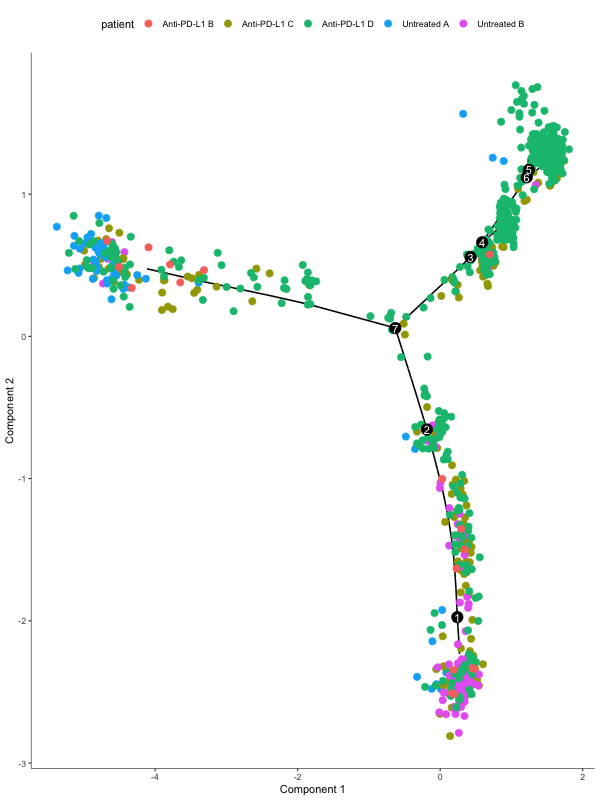

In [36]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
# plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
plot_cell_trajectory(ie_regions_cds, cell_size = 3,  color_by="patient")

In [37]:
%%R -w 600 -h 800
pdf("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/save_pseudotime_plot_CD4_shared_SOC_and_atezo.pdf")
#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="Pseudotime")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue_time")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="cell_calls")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="tissue")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="blood_tumor")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="treatment")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="phase")
print(p)
p <- plot_cell_trajectory(ie_regions_cds, cell_size = 3, color_by="patient")
print(p)
dev.off()

[1] 2


### Plot subset

In [30]:
%%R
ie_regions_cds
dim(ie_regions_cds)


[1] 2028 1005


In [31]:
%%R
# Subset the data atezo
# Anti-PD-L1 D    592
# Anti-PD-L1 C    211
# Untreated B     134
# Untreated A      51
# Anti-PD-L1 B     17
subset_data <- ie_regions_cds[,ie_regions_cds$patient %in% c("Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D", "Untreated A", "Untreated B") ]
subset_data
print(table(pData(subset_data)$patient))


Anti-PD-L1 B Anti-PD-L1 C Anti-PD-L1 D  Untreated A  Untreated B 
          17          211          592           51          134 


In [32]:
%%R

#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(subset_data)$cell_calls)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("GZMB+","GZMK+","CXCL13+","Tregs","Mito","Naive","Prolif GZMK+","CM","MAIT","Activated","IFN+")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")


#Filter highly variable genes from our analysis
hvg_mask = fData(subset_data)$highly_variable
subset_data <- subset_data[hvg_mask, cell_mask]

#Do dimensionality reduction
subset_data <- reduceDimension(subset_data, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)

#Run for the first time to get the ordering
subset_data <- orderCells(subset_data)

# #Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(subset_data)$State, pData(subset_data)$cell_calls)
id = which(colnames(tab1) == 'GZMB+')
root_name = names(which.max(tab1[,id]))

# #Run a second time to get the correct root state that overlaps with Stem cells
subset_data <- orderCells(subset_data, root_state=root_name)

[1] "Number of cells after filtering:"
[1] 1005
[1] ""


In [33]:
# plot_cell_trajectory(subset_data, cell_size = 3, color_by="Pseudotime")

In [34]:
%%R
print(dim(subset_data))
cds <- subset_data
x = 1
 y = 2
  color_by = "State"
   show_tree = TRUE 
    show_backbone = TRUE
     backbone_color = "black"
      markers = NULL
    use_color_gradient = FALSE
     markers_linear = FALSE
      show_cell_names = FALSE 
    show_state_number = FALSE
     cell_size = 1.5
      cell_link_size = 0.75 
    cell_name_size = 2
     state_number_size = 2.9
      show_branch_points = TRUE 
    theta = 0

Features  Samples 
    2028     1005 


In [35]:
%%R
library(magrittr)
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)

library(ggplot2)
library(plyr)
library(MAST)
library(dplyr)
library(tibble)

# Load required namespace
    requireNamespace("igraph")

    # Initial variable declarations
    gene_short_name <- NA
    sample_name <- NA
    sample_state <- pData(cds)$State
    data_dim_1 <- NA
    data_dim_2 <- NA
    lib_info_with_pseudo <- pData(cds)

    # Check for dimension reduction
    if (is.null(cds@dim_reduce_type)) {
        stop("Error: dimensionality not yet reduced. Please call reduceDimension() before calling this function.")
    }

    # Fetch reduced dimensional coordinates based on dimension reduction type
    if (cds@dim_reduce_type == "ICA") {
        reduced_dim_coords <- reducedDimS(cds)
    } else if (cds@dim_reduce_type %in% c("simplePPT", "DDRTree")) {
        reduced_dim_coords <- reducedDimK(cds)
    } else {
        stop("Error: unrecognized dimensionality reduction method.")
    }
    # Transform reduced dimension data to dataframe
    ica_space_df <- Matrix::t(reduced_dim_coords) %>% as.data.frame() %>% 
        select_(prin_graph_dim_1 = x, prin_graph_dim_2 = y) %>% 
        mutate(sample_name = rownames(.), sample_state = rownames(.))


    # Minimum spanning tree
    dp_mst <- minSpanningTree(cds)
    if (is.null(dp_mst)) {
        stop("You must first call orderCells() before using this function")
    }

    # Edge data frame preparation
    edge_df <- dp_mst %>% igraph::as_data_frame() %>% select_(source = "from", 
        target = "to") %>% left_join(ica_space_df %>% select_(source = "sample_name", 
        source_prin_graph_dim_1 = "prin_graph_dim_1", source_prin_graph_dim_2 = "prin_graph_dim_2"), 
        by = "source") %>% left_join(ica_space_df %>% select_(target = "sample_name", 
        target_prin_graph_dim_1 = "prin_graph_dim_1", target_prin_graph_dim_2 = "prin_graph_dim_2"), 
        by = "target")
    # Data frame preparation
    data_df <- t(monocle::reducedDimS(cds)) %>% as.data.frame() %>% 
        select_(data_dim_1 = x, data_dim_2 = y) %>% rownames_to_column("sample_name") %>% 
        mutate(sample_state) %>% left_join(lib_info_with_pseudo %>% 
        rownames_to_column("sample_name"), by = "sample_name")

    # Function to get rotation matrix
    return_rotation_mat <- function(theta) {
        theta <- theta/180 * pi
        matrix(c(cos(theta), sin(theta), -sin(theta), cos(theta)), nrow = 2)
    }

In [39]:
%%R
# Rotate data
    rot_mat <- return_rotation_mat(theta)
    cn1 <- c("data_dim_1", "data_dim_2")
    cn2 <- c("source_prin_graph_dim_1", "source_prin_graph_dim_2")
    cn3 <- c("target_prin_graph_dim_1", "target_prin_graph_dim_2")
    data_df[, cn1] <- as.matrix(data_df[, cn1]) %*% t(rot_mat)
    edge_df[, cn2] <- as.matrix(edge_df[, cn2]) %*% t(rot_mat)
    edge_df[, cn3] <- as.matrix(edge_df[, cn3]) %*% t(rot_mat)

    # Marker expressions processing
    markers_exprs <- NULL
    if (is.null(markers) == FALSE) {
        markers_fData <- subset(fData(cds), gene_short_name %in% 
            markers)
        if (nrow(markers_fData) >= 1) {
            markers_exprs <- reshape2::melt(as.matrix(exprs(cds[row.names(markers_fData), 
                ])))
            colnames(markers_exprs)[1:2] <- c("feature_id", "cell_id")
            markers_exprs <- merge(markers_exprs, markers_fData, 
                by.x = "feature_id", by.y = "row.names")
            markers_exprs$feature_label <- as.character(markers_exprs$gene_short_name)
            markers_exprs$feature_label[is.na(markers_exprs$feature_label)] <- markers_exprs$Var1
        }
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        data_df <- merge(data_df, markers_exprs, by.x = "sample_name", 
            by.y = "cell_id")
        if (use_color_gradient) {
            if (markers_linear) {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2)) + geom_point(aes(color = value), 
                  size = I(cell_size), na.rm = TRUE) + scale_color_viridis(name = paste0("value"), 
                  ...) + facet_wrap(~feature_label)
            }
            else {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2)) + geom_point(aes(color = log10(value + 
                  0.1)), size = I(cell_size), na.rm = TRUE) + 
                  scale_color_viridis(name = paste0("log10(value + 0.1)"), 
                    ...) + facet_wrap(~feature_label)
            }
        }
        else {
            if (markers_linear) {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2, size = (value * 0.1))) + facet_wrap(~feature_label)
            }
            else {
                g <- ggplot(data = data_df, aes(x = data_dim_1, 
                  y = data_dim_2, size = log10(value + 0.1))) + 
                  facet_wrap(~feature_label)
            }
        }
    }
    else {
        g <- ggplot(data = data_df, aes(x = data_dim_1, y = data_dim_2))
    }

### All CD4 as input

In [40]:
%%R
g <- ggplot(data = data_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g


Error in monocle_theme_opts() : 
  could not find function "monocle_theme_opts"


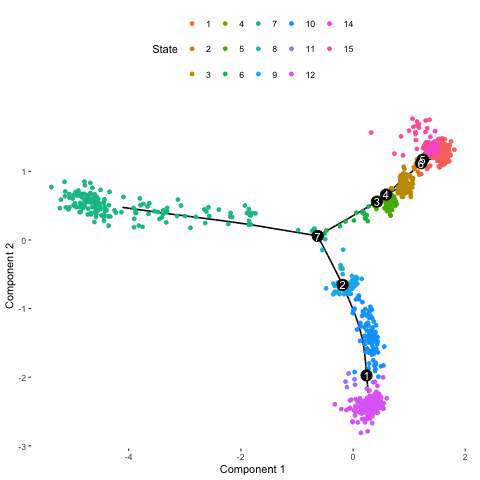

In [44]:
%%R
g <- g + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
g

### atezo CD4 as input

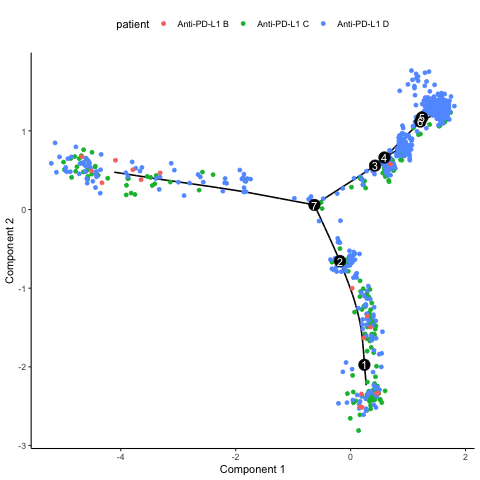

In [97]:
%%R
color_by = "patient"
cell_size = 3

atezoCD4_df <- data_df[data_df$patient %in% c("Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D"),]

g <- ggplot(data = atezoCD4_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g_patient <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g_patient

In [98]:
%%R
# for loop on color codes
atezoCD4_df <- data_df[data_df$patient %in% c("Anti-PD-L1 B", "Anti-PD-L1 C", "Anti-PD-L1 D"),]
cell_size = 3

for(color_by in c("patient", "tissue_time", "cell_calls", "tissue", "blood_tumor", "treatment", "phase", "patient")){

# color_by = "patient"


g <- ggplot(data = atezoCD4_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

    pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD4_atezo_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    dev.off()
}

### SOC Untreated  A B CD4 as input

In [126]:
%%R
# for loop on color codes
Untreated_df <- data_df[data_df$patient %in% c("Untreated A", "Untreated B"),]
cell_size = 3

for(color_by in c("patient", "tissue_time", "cell_calls", "tissue", "blood_tumor", "treatment", "phase", "patient")){

# color_by = "patient"


g <- ggplot(data = Untreated_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

    pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD4_Untreated_SOC_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    dev.off()
}

### Untreated  A B CD4 as input and cell call color code match with other cell call plots (missing MAIT in this plot)

In [45]:
%%R
library(monocle)


In [46]:
%%R
# for loop on color codes
Untreated_df <- data_df[data_df$patient %in% c("Untreated A", "Untreated B"),]
cell_size = 3

for(color_by in c( "cell_calls")){

# color_by = "patient"


g <- ggplot(data = Untreated_df, aes(x = data_dim_1, y = data_dim_2))
if (show_tree) {
        g <- g + geom_segment(aes_string(x = "source_prin_graph_dim_1", 
            y = "source_prin_graph_dim_2", xend = "target_prin_graph_dim_1", 
            yend = "target_prin_graph_dim_2"), size = cell_link_size, 
            linetype = "solid", na.rm = TRUE, data = edge_df)
    }
if (is.null(markers_exprs) == FALSE && nrow(markers_exprs) > 
        0) {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                na.rm = TRUE)
        }
    }
    else {
        if (use_color_gradient) {
        }
        else {
            g <- g + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE)
            
        }
    }
if (show_branch_points && cds@dim_reduce_type == "DDRTree") {
        mst_branch_nodes <- cds@auxOrderingData[[cds@dim_reduce_type]]$branch_points
        branch_point_df <- ica_space_df %>% slice(match(mst_branch_nodes, 
            sample_name)) %>% mutate(branch_point_idx = seq_len(n()))
        g <- g + geom_point(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2"), size = 5, na.rm = TRUE, 
            branch_point_df) + geom_text(aes_string(x = "prin_graph_dim_1", 
            y = "prin_graph_dim_2", label = "branch_point_idx"), 
            size = 4, color = "white", na.rm = TRUE, branch_point_df)
    }
    if (show_cell_names) {
        g <- g + geom_text(aes(label = sample_name), size = cell_name_size)
    }
    if (show_state_number) {
        g <- g + geom_text(aes(label = sample_state), size = state_number_size)
    }
    g <- g + monocle_theme_opts() + xlab(paste("Component", x)) + 
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white"))
    g

    # pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD4_Untreated_SOC_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    # dev.off()
}


Error in monocle_theme_opts() : 
  could not find function "monocle_theme_opts"


In [54]:
%%R
g <- g +  xlab(paste("Component", x)) +  # monocle_theme_opts() +
        ylab(paste("Component", y)) + theme(legend.position = "top", 
        legend.key.height = grid::unit(0.35, "in")) + theme(legend.key = element_blank()) + 
        theme(panel.background = element_rect(fill = "white")) +
        theme(strip.background = element_rect(colour = 'white', fill = 'white')) +
    theme(panel.border = element_blank()) +
    theme(axis.line.x = element_line(size=0.25, color="black")) +
    theme(axis.line.y = element_line(size=0.25, color="black")) +
    theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank()) +
    theme(panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) + 
    theme(panel.background = element_rect(fill='white')) +
    theme(legend.key=element_blank()) + geom_point(aes_string(color = color_by), 
                size = I(cell_size), na.rm = TRUE) +
    scale_color_manual(values = c("GZMB+"="#F8766D","GZMK+"="#B79F00","CXCL13+"="#00BA38","Tregs"="#00BFC4","Prolif GZMK+"="#619CFF","MAIT"="#F564E3"))
    # ggplot2 default color: https://www.statology.org/ggplot-default-colors/
    g

    pdf(paste0("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/CD4_Untreated_SOC_pseudotime_plot_", color_by, ".pdf"))
    print(g)
    dev.off()

[1] 2


In [51]:
%%R
print(table(data_df$cell_calls))


       GZMB+        GZMK+      CXCL13+        Tregs Prolif GZMK+         MAIT 
         648          180           76           70           30            1 


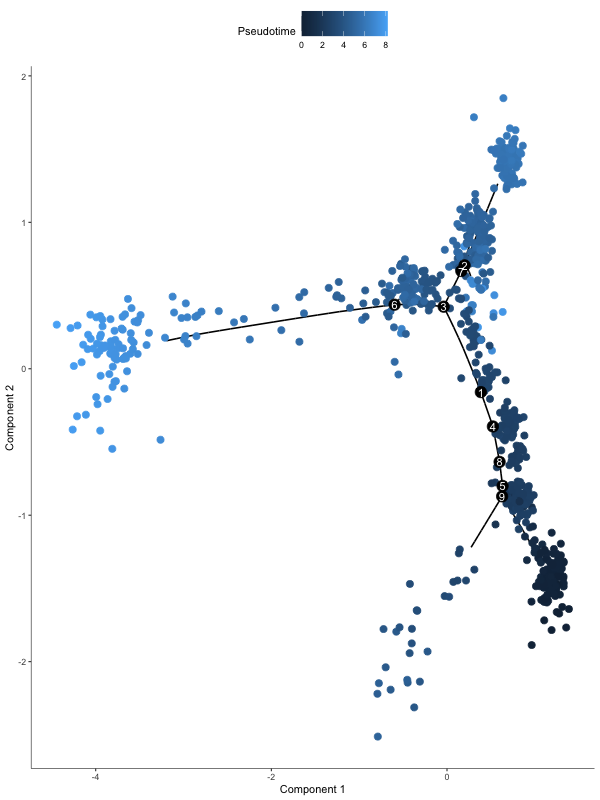

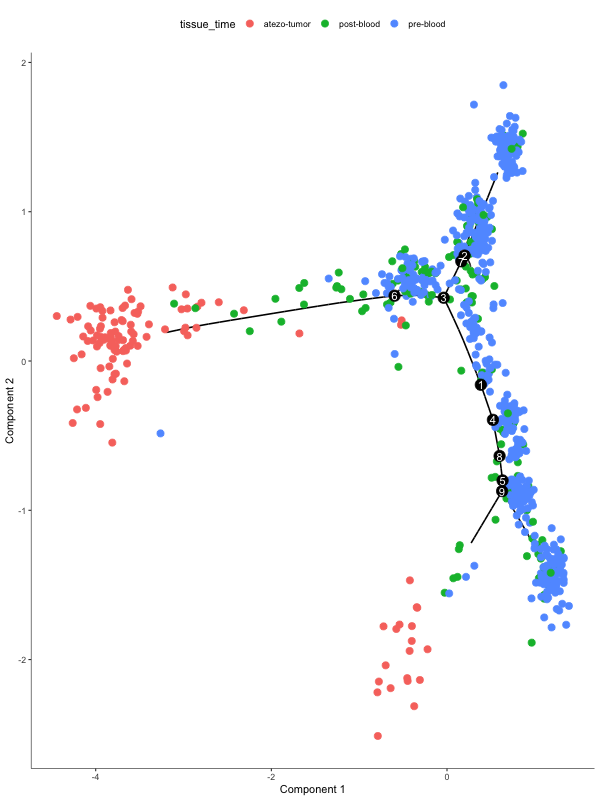

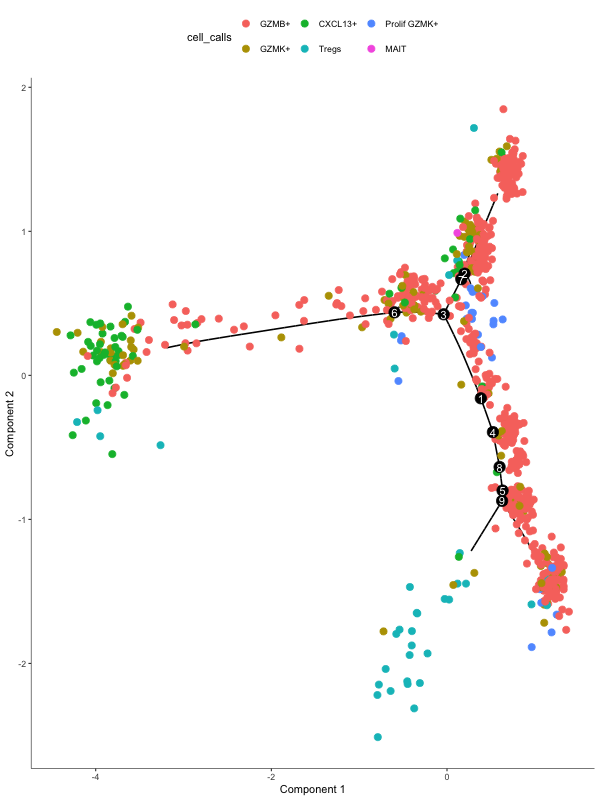

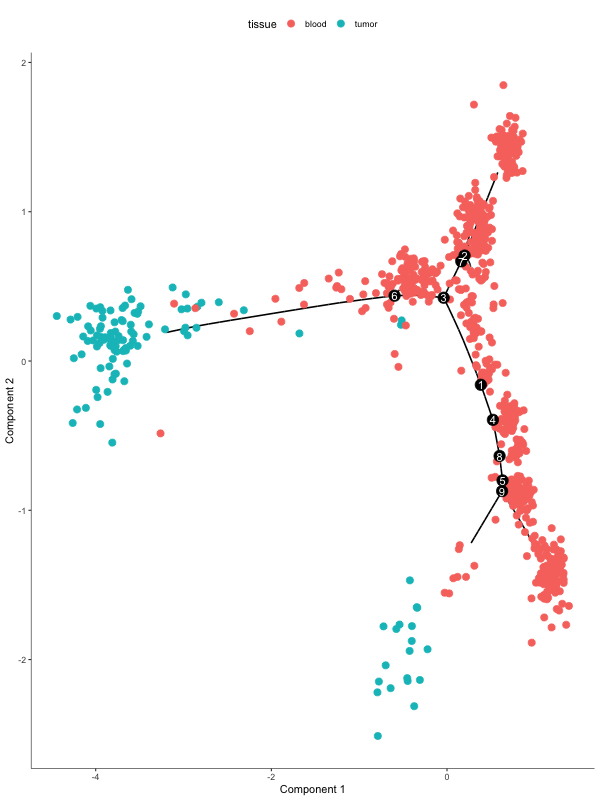

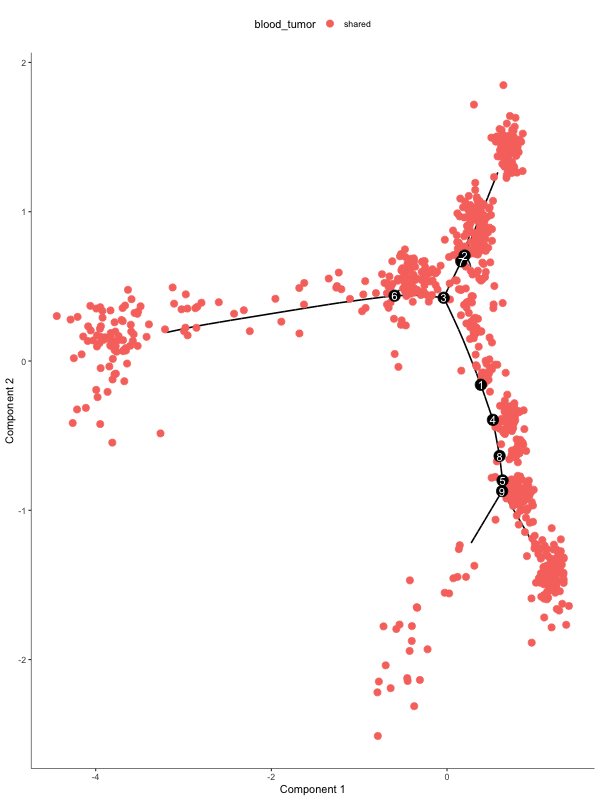

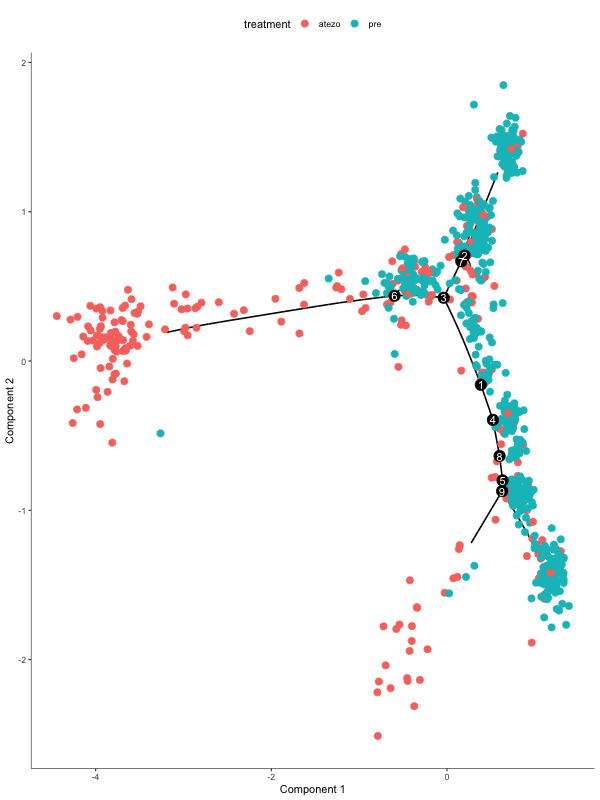

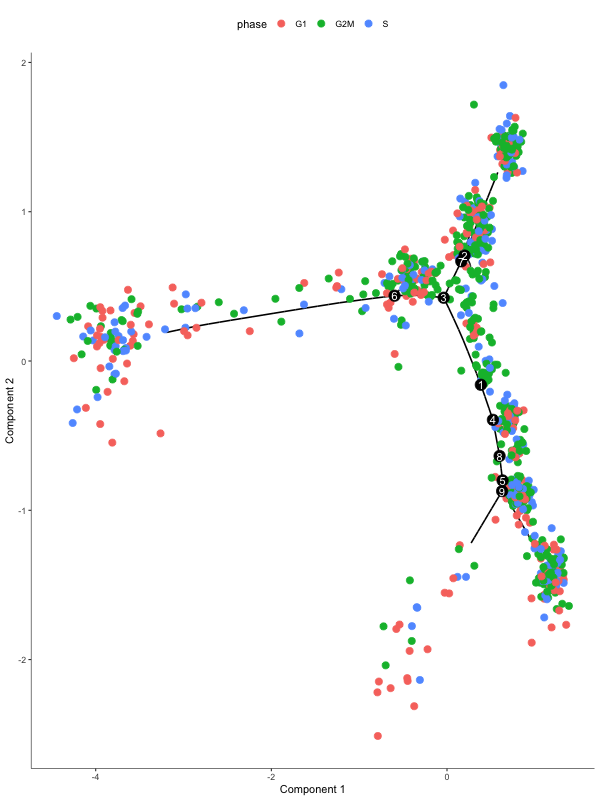

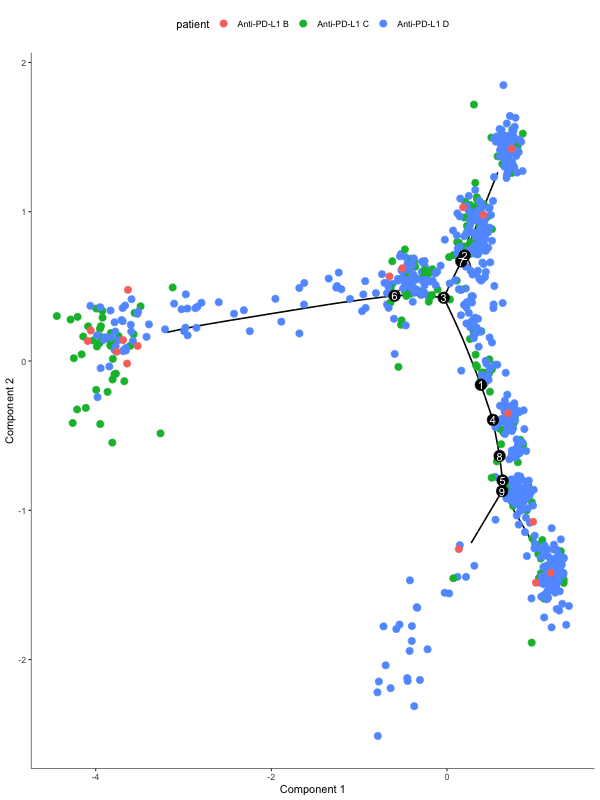

In [46]:
%%R -w 600 -h 800
# pdf("/Users/hai/Documents/workstation/bladder_blood_analysis/scRNA/output_for_paper/pseudotime_analysis/save_pseudotime_plot_CD4_shared_SOC_and_atezo_subset_atezo.pdf")



#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="Pseudotime")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="tissue_time")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="cell_calls")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="tissue")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="blood_tumor")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="treatment")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="phase")
print(p)
p <- plot_cell_trajectory(subset_data, cell_size = 3, color_by="patient")
print(p)
# dev.off()

In [78]:
%%R



Anti-PD-L1 B Anti-PD-L1 C Anti-PD-L1 D 
          17          211          592 


In [57]:
%%R
ie_regions_cds

CellDataSet (storageMode: environment)
assayData: 2028 features, 1005 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames:
    AACACTCTGATAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
    ACGCCACTACTGTG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
    ... TTAGGTCTGTGTTG-1-1-0-0-0 (1005 total)
  varLabels: RBC batch ... State (33 total)
  varMetadata: labelDescription
featureData
  featureNames: LINC00115 NOC2L ... AL354822.1 (2028 total)
  fvarLabels: gene_ids n_cells ... dispersions_norm (6 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  


In [61]:
%%R
phenoData(ie_regions_cds)

An object of class 'AnnotatedDataFrame'
  sampleNames:
    AACACTCTGATAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
    ACGCCACTACTGTG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
    ... TTAGGTCTGTGTTG-1-1-0-0-0 (1005 total)
  varLabels: RBC batch ... State (33 total)
  varMetadata: labelDescription


In [63]:
%%R
varLabels(ie_regions_cds)

 [1] "RBC"                    "batch"                  "comp"                  
 [4] "n_counts"               "n_genes"                "patient"               
 [7] "percent_mito"           "platelet"               "sample"                
[10] "tissue"                 "treatment"              "louvain"               
[13] "leiden"                 "umap_density_comp"      "umap_density_treatment"
[16] "umap_density_tissue"    "cell_calls"             "S_score"               
[19] "G2M_score"              "phase"                  "cell.barcode"          
[22] "index_col"              "degree"                 "tcr_cluster_id"        
[25] "expansion"              "blood_tumor"            "expand"                
[28] "tcr_alpha_beta"         "Patient_ID"             "tissue_time"           
[31] "Size_Factor"            "Pseudotime"             "State"                 
